In [6]:
import sqlite3
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import timedelta
from pandas.core.groupby.generic import DataFrameGroupBy
from icecream import ic
import re
import sys
sys.path.append("..")
from src.fpl.pipelines.model_pipeline.preprocessing.elo_calculation import calculate_elo_score
import matplotlib.pyplot as plt


In [3]:
conn = sqlite3.connect("../data/fpl.db")
train_val_data = pd.read_sql(f"select * from train_val_data", conn)
conn.close()
display(train_val_data.head())

,season,fpl_name,round,date,player,venue,team,opponent,pos,value,...,match_points_ma2,match_points_ma3,match_points_ma4,match_points_ma5,league_points_ma1,league_points_ma2,league_points_ma3,league_points_ma4,league_points_ma5,fpl_points
0,2016-2017,Aaron Lennon,1.0,2016-08-13 00:00:00.000000,Aaron Lennon,Home,Everton,Tottenham,MF,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,2016-2017,Marten de Roon,1.0,2016-08-13 00:00:00.000000,Marten de Roon,Home,Middlesbrough,Stoke City,DM,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2016-2017,Martin Kelly,1.0,2016-08-13 00:00:00.000000,Martin Kelly,Home,Crystal Palace,West Brom,DF,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,2016-2017,Mason Holgate,1.0,2016-08-13 00:00:00.000000,Mason Holgate,Home,Everton,Tottenham,CB,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,2016-2017,Matt Phillips,1.0,2016-08-13 00:00:00.000000,Matt Phillips,Away,West Brom,Crystal Palace,RM,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0


In [4]:
X_train_val = train_val_data[["round","value","att_total","home_att_total","away_att_total","def_total","home_def_total","away_def_total","pts_b4_match","rank_b4_match","pts_gap_above","pts_gap_below","min_ma1","gls_ma1","ast_ma1","pk_ma1","pkatt_ma1","sh_ma1","sot_ma1","touches_ma1","xg_ma1","npxg_ma1","xag_ma1","sca_ma1","gca_ma1","sota_ma1","ga_ma1","saves_ma1","savepct_ma1","cs_ma1","psxg_ma1","team_poss_ma1","team_gf_ma1","team_ga_ma1","team_xg_ma1","team_xga_ma1","fpl_points_ma1","value_ma1","att_elo_ma1","def_elo_ma1","home_att_elo_ma1","home_def_elo_ma1","away_att_elo_ma1","away_def_elo_ma1","att_elo_opp_ma1","def_elo_opp_ma1","home_att_elo_opp_ma1","home_def_elo_opp_ma1","away_att_elo_opp_ma1","away_def_elo_opp_ma1","att_total_ma1","home_att_total_ma1","away_att_total_ma1","def_total_ma1","home_def_total_ma1","away_def_total_ma1","match_points_ma1","league_points_ma1","min_ma2","gls_ma2","ast_ma2","pk_ma2","pkatt_ma2","sh_ma2","sot_ma2","touches_ma2","xg_ma2","npxg_ma2","xag_ma2","sca_ma2","gca_ma2","sota_ma2","ga_ma2","saves_ma2","savepct_ma2","cs_ma2","psxg_ma2","team_poss_ma2","team_gf_ma2","team_ga_ma2","team_xg_ma2","team_xga_ma2","fpl_points_ma2","value_ma2","att_elo_ma2","def_elo_ma2","home_att_elo_ma2","home_def_elo_ma2","away_att_elo_ma2","away_def_elo_ma2","att_elo_opp_ma2","def_elo_opp_ma2","home_att_elo_opp_ma2","home_def_elo_opp_ma2","away_att_elo_opp_ma2","away_def_elo_opp_ma2","att_total_ma2","home_att_total_ma2","away_att_total_ma2","def_total_ma2","home_def_total_ma2","away_def_total_ma2","match_points_ma2","league_points_ma2","min_ma3","gls_ma3","ast_ma3","pk_ma3","pkatt_ma3","sh_ma3","sot_ma3","touches_ma3","xg_ma3","npxg_ma3","xag_ma3","sca_ma3","gca_ma3","sota_ma3","ga_ma3","saves_ma3","savepct_ma3","cs_ma3","psxg_ma3","team_poss_ma3","team_gf_ma3","team_ga_ma3","team_xg_ma3","team_xga_ma3","fpl_points_ma3","value_ma3","att_elo_ma3","def_elo_ma3","home_att_elo_ma3","home_def_elo_ma3","away_att_elo_ma3","away_def_elo_ma3","att_elo_opp_ma3","def_elo_opp_ma3","home_att_elo_opp_ma3","home_def_elo_opp_ma3","away_att_elo_opp_ma3","away_def_elo_opp_ma3","att_total_ma3","home_att_total_ma3","away_att_total_ma3","def_total_ma3","home_def_total_ma3","away_def_total_ma3","match_points_ma3","league_points_ma3","min_ma4","gls_ma4","ast_ma4","pk_ma4","pkatt_ma4","sh_ma4","sot_ma4","touches_ma4","xg_ma4","npxg_ma4","xag_ma4","sca_ma4","gca_ma4","sota_ma4","ga_ma4","saves_ma4","savepct_ma4","cs_ma4","psxg_ma4","team_poss_ma4","team_gf_ma4","team_ga_ma4","team_xg_ma4","team_xga_ma4","fpl_points_ma4","value_ma4","att_elo_ma4","def_elo_ma4","home_att_elo_ma4","home_def_elo_ma4","away_att_elo_ma4","away_def_elo_ma4","att_elo_opp_ma4","def_elo_opp_ma4","home_att_elo_opp_ma4","home_def_elo_opp_ma4","away_att_elo_opp_ma4","away_def_elo_opp_ma4","att_total_ma4","home_att_total_ma4","away_att_total_ma4","def_total_ma4","home_def_total_ma4","away_def_total_ma4","match_points_ma4","league_points_ma4","min_ma5","gls_ma5","ast_ma5","pk_ma5","pkatt_ma5","sh_ma5","sot_ma5","touches_ma5","xg_ma5","npxg_ma5","xag_ma5","sca_ma5","gca_ma5","sota_ma5","ga_ma5","saves_ma5","savepct_ma5","cs_ma5","psxg_ma5","team_poss_ma5","team_gf_ma5","team_ga_ma5","team_xg_ma5","team_xga_ma5","fpl_points_ma5","value_ma5","att_elo_ma5","def_elo_ma5","home_att_elo_ma5","home_def_elo_ma5","away_att_elo_ma5","away_def_elo_ma5","att_elo_opp_ma5","def_elo_opp_ma5","home_att_elo_opp_ma5","home_def_elo_opp_ma5","away_att_elo_opp_ma5","away_def_elo_opp_ma5","att_total_ma5","home_att_total_ma5","away_att_total_ma5","def_total_ma5","home_def_total_ma5","away_def_total_ma5","match_points_ma5","league_points_ma5"]]

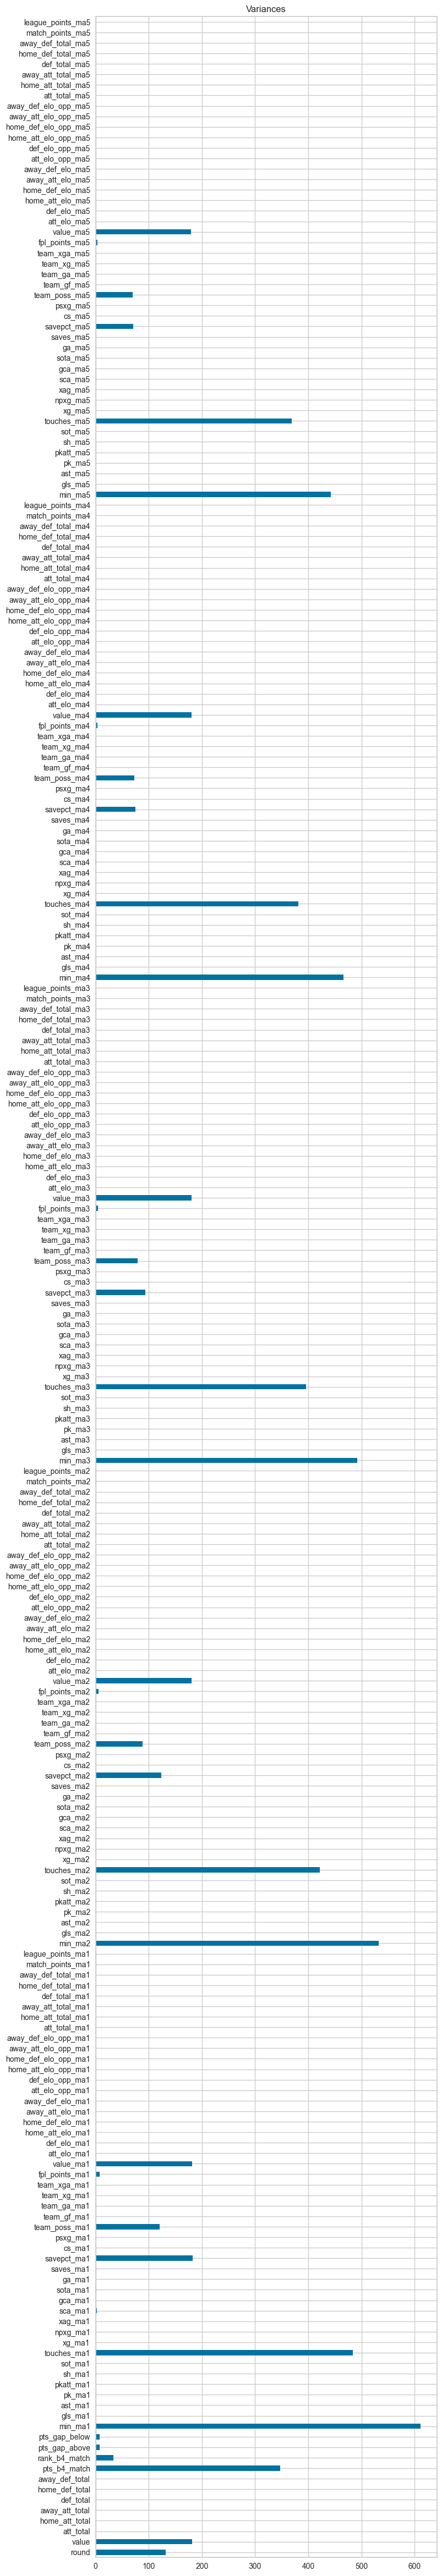

In [18]:
variance_values = X_train_val.var()
feature_selection_summary = pd.DataFrame(
    {"Column": variance_values.index, "Variance": variance_values.values}
)

ax = variance_values.plot(
    kind="barh", title=f"Variances", figsize=(8, 60)
)